# <h1><center> Predictive Analysis - Porto Seguro’s Safe Driver Prediction | Kaggle

# <h1><center> I. Importation & Data Cleaning

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.graph_objs as go              # 可用于绘制不同图型，如 go.bar()
import plotly.express as px                 # 可用于绘制不同图型，如 px.bar()
from plotly.subplots import make_subplots   # 创建子图
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)    #THIS LINE IS MOST IMPORTANT AS THIS WILL DISPLAY PLOT ON 
#NOTEBOOK WHILE KERNEL IS RUNNING

In [57]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

In [58]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [59]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [60]:
# Missing values statistics
missing_values = missing_values_table(train)  # app_train 是一个 dataframe
missing_values.head(20)

Your selected dataframe has 59 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# <center>II. Aggregation & Visualisation

In [ ]:
# train_counts = train.target.value_counts()
# train_counts = pd.DataFrame(train_counts)

# fig = px.bar(train_counts,x=train_counts.index,y='target',barmode='group',color='target')
# fig.update_traces(textposition='outside')
# fig.update_layout(template='seaborn',title='target (counts)')
# fig.show()

In [61]:
train_counts = train.target.value_counts()
train_counts = pd.DataFrame(train_counts)

fig = px.bar(train_counts,x=train_counts.index,y='target',barmode='group',color='target',text='target') # text 可以标上数值
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title='counts',xaxis_title='target',template='seaborn',title='target (counts)')
fig.show()

## 数据不平衡

可以发现标签之前存在不平衡的状态，如果数据存在严重的不平衡，预测得出的结论往往也是有偏的，即分类结果会偏向于较多观测的类。

比如我们使用准确率来进行模型的评估，即使我们全部预测成 `target == 0`，那么也有很高的准确率: `573518/(573518+21694)=0.96`。

所以对于分类不平衡的数据，我们可以进行如下操作：

### 欠采样：

随机欠采样（下采样）的目标是通过随机地消除占多数的类的样本来平衡类分布；直到多数类和少数类的实例实现平衡，目标才算达成。

* `随机欠采样（下采样）`的目标是通过随机地消除占多数的类的样本来平衡类分布；直到多数类和少数类的实例实现平衡，目标才算达成。

* `随机下采样的优点：`
    
    它可以提升运行时间；并且当训练数据集很大时，可以通过减少样本数量来解决存储问题。

* `随机下采样的缺点：`
    
    它会丢弃对构建规则分类器很重要的有价值的潜在信息。

    被随机欠采样选取的样本可能具有偏差。它不能准确代表大多数。从而在实际的测试数据集上得到不精确的结果。果。


### 过采样


* `随机过采样` 通过随机复制少数类来增加其中的实例数量，从而可增加样本中少数类的代表性。

* `随机过采样的优点：`

    与欠采样不同，这种方法不会带来信息损失。

    表现优于欠采样。

* `随机过采样的缺点：`
    
    由于复制少数类事件，它加大了过拟合的可能性。
    

本 notebook 将采用 SMOTE 来进行过采样

In [83]:
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

### 不进行采样，直接进行模型训练和预测查看模型质量

* 通过对比准确度和召回率
    
* 通过绘制混淆矩阵

### 1、对比准确度和召回率

可以看到，即使你的准确率非常高，但是召回率却非常低    

In [77]:
train_target = train['target']
train_feature = train.drop(columns='target')

x_train,x_test,y_train,y_test = train_test_split(train_feature,train_target,test_size= 0.2,random_state=10)

# model = XGBClassifier(n_estimators=1000)
model = XGBClassifier()


model.fit(x_train,y_train)
y_pred = model.predict(x_test)

acc = accuracy_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('Accuracy: {:.3f}'.format(acc* 100.0))
print('recall: {:.3f}'.format(recall* 100.0))

Accuracy: 96.288
recall: 0.045


### 2、绘制混淆矩阵

混淆矩阵用法示例，用于评估数据集上分类器输出的质量。 对角线元素表示预测标签等于真实标签的点数，而非对角线元素则是分类器未正确标记的元素。 混淆矩阵的对角线值越高，表示对数越多越好。混淆矩阵用法示例，用于评估数据集上分类器输出的质量。 对角线元素表示预测标签等于真实标签的点数，而非对角线元素则是分类器未正确标记的元素。 混淆矩阵的对角线值越高，表示对数越多越好。

In [88]:
def plot_confusion_matrix(cm, classes,
                                normalize=False,
                                title='Confusion matrix',
                                cmap=plt.cm.Blues):
        """
            此函数打印并绘制混淆矩阵。
            可以通过设置“ normalize = True”来应用归一化。
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[114622     11]
 [  4408      2]]


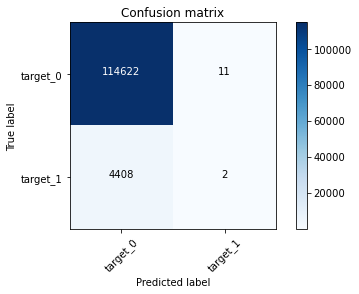

In [92]:
classes = ['target_0','target_1'] # 顺序别搞错
np.set_printoptions(precision=2)

cm = confusion_matrix(y_test,y_pred)
plt.figure()
plot_confusion_matrix(cm,classes)
plt.show()

# plt.figure()
# plot_confusion_matrix(cm,classes,normalize=True)
# plt.show()

### 使用 SMOTE 进行过采样

In [103]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### 查看2D数据的分布

label0:  458885
label1:  17284


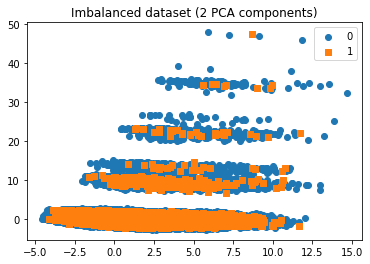

In [107]:
# 定义绘图函数
def plot_2d_space(X, y, label='Classes'):   
            colors = ['#1F77B4', '#FF7F0E']
            markers = ['o', 's']
            for l, c, m in zip(np.unique(y), colors, markers):
                plt.scatter(
                    X[y==l, 0],
                    X[y==l, 1],
                    c=c, label=l, marker=m
                )
            plt.title(label)
            plt.legend(loc='upper right')
            plt.show()
            
print("label0: ",len(x_train[y_train==0]))
print("label1: ",len(x_train[y_train==1]))

ss = StandardScaler()
X = ss.fit_transform(x_train)

# `2、`如果数据存在多维特征可使用PCA来降维，使其能在2D图中展示

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y_train, 'Imbalanced dataset (2 PCA components)')

In [108]:
oversampler=SMOTE(random_state=0)
# 开始人工合成数据
os_features,os_labels=oversampler.fit_sample(x_train,y_train)

# 查看生成结果
print("label1: ",len(os_labels[os_labels==1]))
print("label0: ",len(os_labels[os_labels==0]))

label1:  458885
label0:  458885


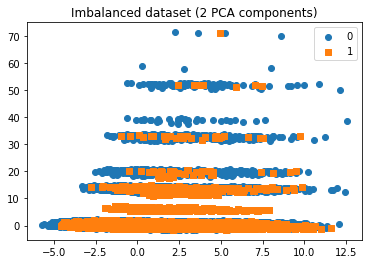

In [110]:
ss = StandardScaler()
X = ss.fit_transform(os_features)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, os_labels, 'Imbalanced dataset (2 PCA components)')

### 特征相关性检测

In [121]:
new_os_features = os_features.copy()
new_os_features['target'] = os_labels

# Find correlations with the target and sort
correlations = new_os_features.corr()['target'].sort_values(ascending=False)
correlations = pd.DataFrame(correlations)

# Display correlations
print('Most Negative Correlations:\n', correlations.head(15))
print('\nMost Positive Correlations:\n',correlations.tail(15))

Most Negative Correlations:
                  target
target         1.000000
ps_car_13      0.144555
ps_car_03_cat  0.130395
ps_car_12      0.109132
ps_reg_02      0.096879
ps_reg_03      0.087005
ps_car_15      0.082356
ps_car_05_cat  0.079734
ps_reg_01      0.064985
ps_car_04_cat  0.048305
ps_ind_05_cat  0.039010
ps_car_11_cat  0.015791
ps_calc_02     0.006981
ps_calc_03     0.006067
ps_calc_01     0.003580

Most Positive Correlations:
                   target
ps_calc_04     -0.176467
ps_ind_08_bin  -0.197155
ps_calc_15_bin -0.201505
ps_ind_18_bin  -0.210137
ps_calc_20_bin -0.218281
ps_car_08_cat  -0.221036
ps_calc_16_bin -0.223038
ps_ind_04_cat  -0.227222
ps_calc_17_bin -0.238716
ps_ind_09_bin  -0.244397
ps_calc_18_bin -0.253797
ps_car_02_cat  -0.256188
ps_calc_19_bin -0.258783
ps_ind_16_bin  -0.303274
ps_ind_06_bin  -0.338307


# <center>III. ML Approach

In [111]:
os_features.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,614652,4,2,5,0,0,1,0,0,0,...,6,2,5,16,1,1,0,1,1,0
1,1219186,1,1,3,1,0,1,0,0,0,...,4,0,3,8,0,1,1,0,0,0
2,817014,1,1,6,0,6,1,0,0,0,...,5,1,1,11,0,1,1,0,1,0
3,556023,2,2,0,0,0,0,0,0,1,...,5,3,4,3,0,1,1,0,0,0
4,1387271,1,2,2,0,0,0,0,1,0,...,8,0,1,11,0,1,1,0,1,0
